# Eigenpair tracking demonstration on a high-dimensional matrix path

This notebook tracks eigenpairs along a 12-dimensional matrix path and compares correction strategies.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from eigenpairflow import eigenpairtrack

## Problem setup

Construct a matrix path $A(t)$ by linearly interpolating two random symmetric matrices $A_0$ and $A_1$.

In [2]:
n = 12
t_eval = np.linspace(0.0, 1.0, 100)

np.random.seed(0)

def rand_near_orthogonal_cayley(Q0, eps=6.0e-3):
    n = Q0.shape[0]
    U = np.triu(np.random.randn(n, n), 1)
    S = eps * (U - U.T)
    R = np.linalg.solve(np.eye(n) - S, np.eye(n) + S)   # (I-S)^{-1}(I+S)
    return Q0 @ R

# perturb the rotation to induce both curve crossing and curve veering
Q0, _ = np.linalg.qr(np.random.randn(n, n))
Q1 = rand_near_orthogonal_cayley(Q0)

# flip eigenvalues to create crossings
eigvals0 = np.random.uniform(0, 1, n)
eigvals1 = eigvals0[::-1]

A0 = Q0 @ np.diag(eigvals0) @ Q0.T
A1 = Q1 @ np.diag(eigvals1) @ Q1.T

def A_func(t):
    """Return the interpolated symmetric matrix A(t)."""
    return (1 - t) * A0 + t * A1

def dA_func(t):
    """Return the derivative of A(t) with respect to t."""
    return A1 - A0

## solve_ivp (DOP853) + Ogita-Aishima correction

In [3]:
start = time()
result_ode = eigenpairtrack(
    A_func,
    dA_func,
    (0.0, 1.0),
    t_eval,
    solver_method="DOP853",
    correction_method="ogita_aishima",
)
elapsed_ode = time() - start

print('DOP853 integration + Ogita-Aishima (ode)')
print('=' * 40)
print(f'Time: {elapsed_ode} secs')
print(result_ode)

DOP853 integration + Ogita-Aishima (ode)
Time: 1.6196651458740234 secs
EigenTrackingResults Summary:
success: True
message: The solver successfully reached the end of the integration interval.
  t_eval: np.ndarray with shape (100,)
  Qs: list of 100 np.ndarray(s), first shape: (12, 12)
  Lambdas: list of 100 np.ndarray(s), first shape: (12, 12)


## Ogita-Aishima Iteration Method

In [4]:
start = time()
result_oa = eigenpairtrack(
    A_func,
    dA_func,
    (0.0, 1.0),
    t_eval
)
elapsed_oa = time() - start

print('Ogita-Aishima Iteration (oa)')
print('=' * 28)
print(f'Time: {elapsed_oa} secs')
print(result_oa)

Ogita-Aishima Iteration (oa)
Time: 0.02448296546936035 secs
EigenTrackingResults Summary:
success: True
message: Ogita-Aishima
  t_eval: np.ndarray with shape (100,)
  Qs: list of 100 np.ndarray(s), first shape: (12, 12)
  Lambdas: list of 100 np.ndarray(s), first shape: (12, 12)


## Tracked eigenvalues

We can observe both eigenvalue curves' crossing and veering.

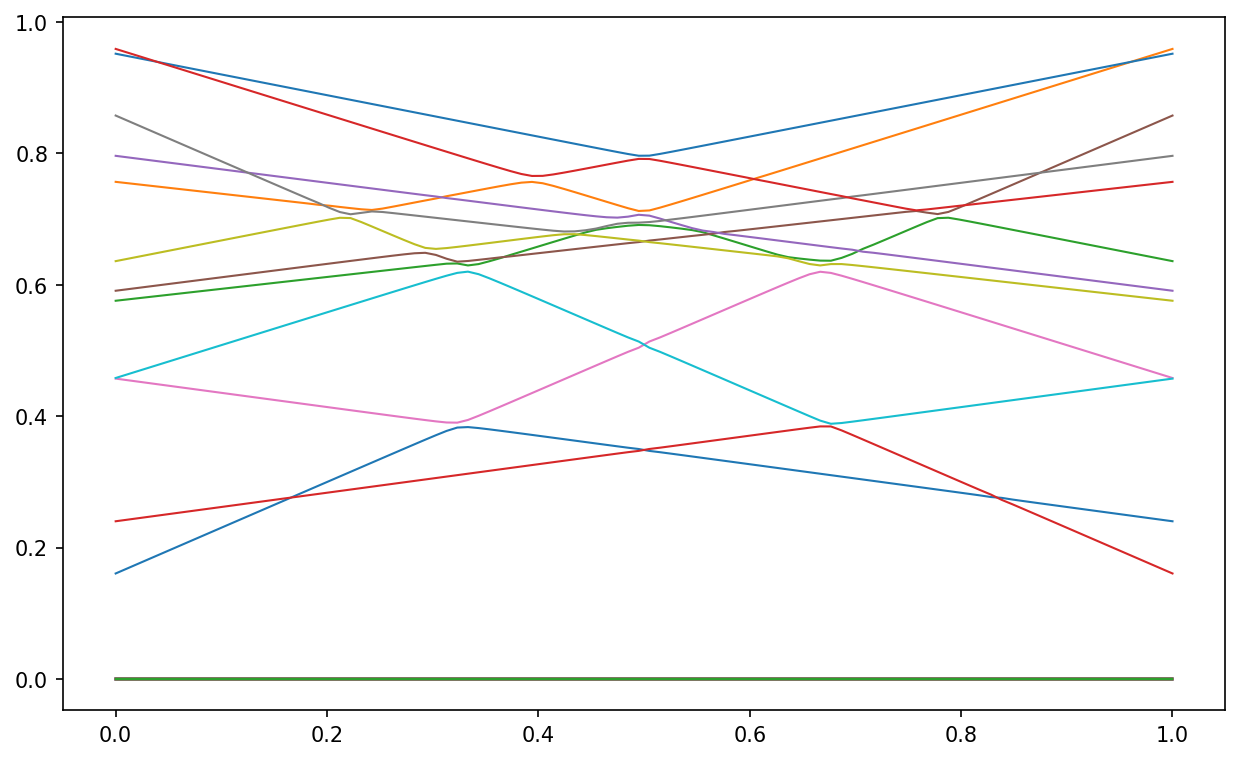

In [5]:
plt.figure(figsize=(10, 6), dpi=150)
eigvals = np.array(result_oa.Lambdas)

for i in range(n):
    plt.plot(t_eval, eigvals[:, i], lw=1)

## Error and runtime comparison

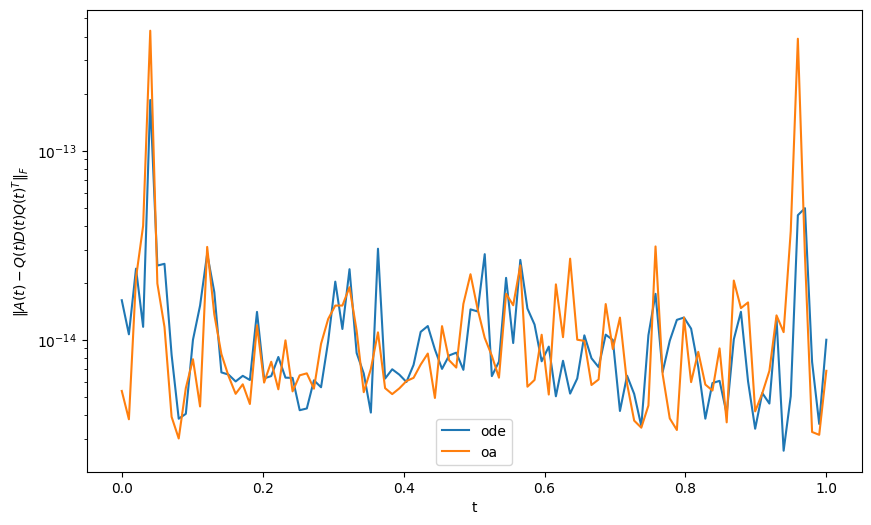

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(t_eval, result_ode.norm_errors, label='ode')
plt.plot(t_eval, result_oa.norm_errors, label='oa')
plt.yscale('log')
plt.xlabel('t')
plt.ylabel(r'$\|A(t) - Q(t)D(t)Q(t)^T\|_F$')
plt.legend()
plt.show()

In [7]:
print(f'{np.sum(result_ode.norm_errors)=}')
print(f'{np.sum(result_oa.norm_errors)=}')

np.sum(result_ode.norm_errors)=1.245934862305756e-12
np.sum(result_oa.norm_errors)=1.842386390648675e-12
